In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

In [2]:
print(os.getcwd())

/Users/deng/ws/sports_data_analysis


In [3]:
files = glob.glob('../data/garmin/*_en.csv')

dfs = []

for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df = df[['Activity Type', 'Date', 'Title', 'Distance', 'Time', 'Calories', 'Avg Pace']]

# swimming distance has a thousand delimiter
df['Distance'] = df['Distance'].str.replace(',', '')
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

df['Time'] = pd.to_timedelta(df['Time']).dt.total_seconds()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Activity Type  1687 non-null   object 
 1   Date           1687 non-null   object 
 2   Title          1687 non-null   object 
 3   Distance       1671 non-null   float64
 4   Time           1687 non-null   float64
 5   Calories       1687 non-null   object 
 6   Avg Pace       1687 non-null   object 
dtypes: float64(2), object(5)
memory usage: 92.4+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')
df['Day'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Activity Type  1687 non-null   object        
 1   Date           1687 non-null   datetime64[ns]
 2   Title          1687 non-null   object        
 3   Distance       1671 non-null   float64       
 4   Time           1687 non-null   float64       
 5   Calories       1687 non-null   object        
 6   Avg Pace       1687 non-null   object        
 7   Month          1687 non-null   period[M]     
 8   Day            1687 non-null   object        
 9   Hour           1687 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(5), period[M](1)
memory usage: 125.3+ KB


In [6]:
df.head()


,Activity Type,Date,Title,Distance,Time,Calories,Avg Pace,Month,Day,Hour
0,Pool Swim,2023-12-31 09:54:32,BAC Swimming,2000.00,2894.0,469,2:23,2023-12,Sunday,9
1,Running,2023-12-30 12:17:50,Charlottetown Running,8.68,3250.0,497,6:15,2023-12,Saturday,12
2,Running,2023-12-28 07:02:09,Charlottetown Running,8.64,3295.0,520,6:21,2023-12,Thursday,7
3,Pool Swim,2023-12-27 20:06:51,BAC Swimming,1350.00,1978.0,317,2:26,2023-12,Wednesday,20
4,Running,2023-12-26 09:42:06,Charlottetown Running,8.53,3298.0,508,6:27,2023-12,Tuesday,9


In [7]:
df_run = df[df['Activity Type'] == 'Running']

In [8]:
matplotlib.rcParams['font.family'] = ['Heiti TC']

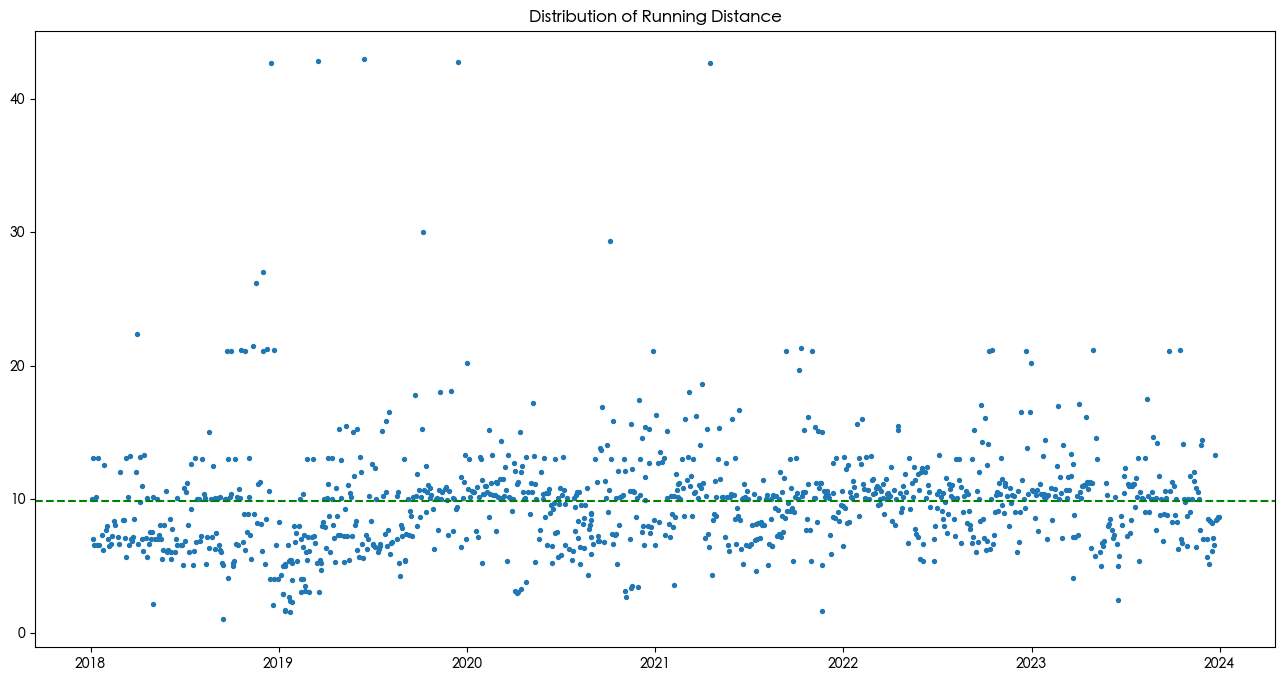

In [9]:
plt.figure(figsize=(16, 8)) 
avg = df_run['Distance'].mean()
plt.axhline(y=avg, color='g', linestyle='--', label='Average')
plt.scatter(df_run['Date'], df_run['Distance'],8)
plt.title('Distribution of Running Distance')
plt.show()

In [10]:
monthly_sum = df_run.groupby('Month')['Distance'].sum()
monthly_sum = monthly_sum[monthly_sum > 50] #remove 2017-11 first record

monthly_sum.head()

Month
2018-01    114.77
2018-02     69.59
2018-03    136.78
2018-04    118.59
2018-05    101.29
Freq: M, Name: Distance, dtype: float64

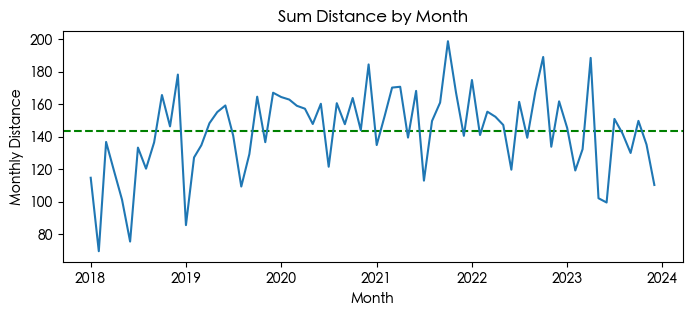

In [11]:
monthly_sum.index = monthly_sum.index.to_timestamp()
plt.figure(figsize=(8, 3)) 
avg = monthly_sum.mean()
plt.axhline(y=avg, color='g', linestyle='--', label='Average')
plt.plot(monthly_sum.index, monthly_sum.values)
plt.title('Sum Distance by Month')
plt.xlabel('Month')
plt.ylabel('Monthly Distance')
plt.show()

In [12]:
monthly_count = df.groupby('Month')['Distance'].count()
monthly_count = monthly_count[monthly_count > 2] #remove 2017-11 first record

monthly_count.head()

Month
2018-01    13
2018-02     9
2018-03    14
2018-04    14
2018-05    14
Freq: M, Name: Distance, dtype: int64

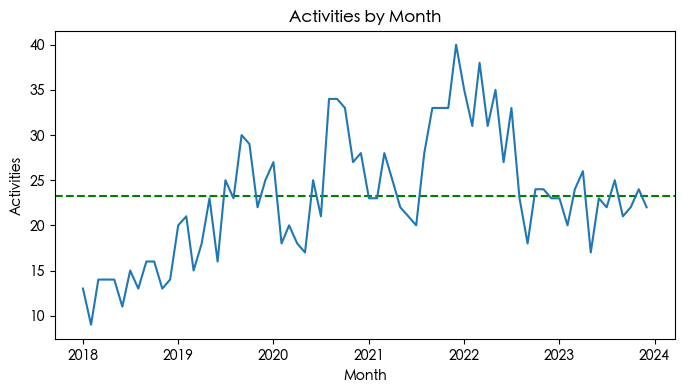

In [13]:
monthly_count.index = monthly_count.index.to_timestamp()
plt.figure(figsize=(8, 4)) 
avg = monthly_count.mean()
plt.axhline(y=avg, color='g', linestyle='--', label='Average')
plt.plot(monthly_count.index, monthly_count.values)
plt.title('Activities by Month')
plt.xlabel('Month')
plt.ylabel('Activities')
plt.show()

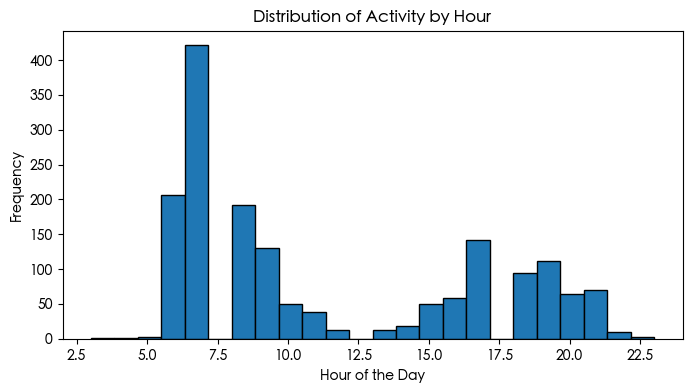

In [14]:
plt.figure(figsize=(8, 4))
plt.hist(df['Hour'], bins=24, edgecolor='black')

plt.title('Distribution of Activity by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.show()

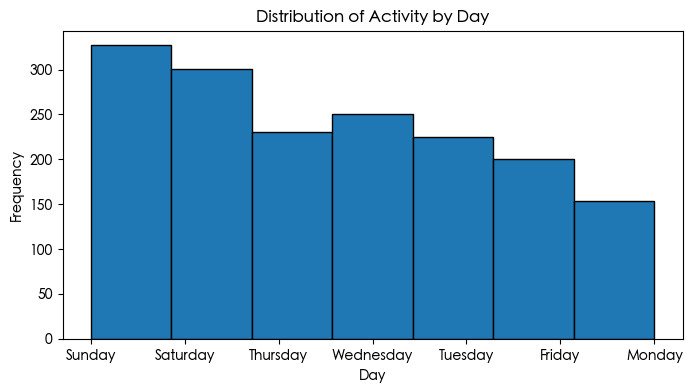

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(df['Day'], bins=7, edgecolor='black')

plt.title('Distribution of Activity by Day')
plt.xlabel('Day')
plt.ylabel('Frequency')

plt.show()

In [35]:
def merge_place(place):
    p = place.replace('广州-', '')
    if ('深圳' in place):
        p = '深圳'
    return p

def extract_running_place(title):
    t = title.replace('-Manual', '')
    items = t.split('-')
    ilen = len(items)
    t = ''               
    if ilen > 2:
        t = '-'.join(items[:2])
    elif ilen == 2:
        t = items[0]
    else:
        t = items[0].split(' Running')[0]
    
    #print(title, '-->', t)
    return merge_place(t)

df_run['Place'] = df_run['Title'].apply(extract_running_place)
places = df_run['Place'].unique()
print(places)

['Charlottetown' 'Saint John' 'Summerside' 'Stratford' 'Queens' '珠江公园'
 '生物岛' '江边' '奥体' '深圳' '大学城' '广东-惠州' '北京-玉渊潭' '广东-英德' '广西-阳朔' '旭景' '天鹿山'
 '贵州-贵阳' '大夫山' '海珠湖' '珠江新城' '华农' '广东-清远' '天体' '二沙岛' '湖北-京山' '香港' '广东-佛山'
 '海南-万宁' '海南-琼海' '海南-文昌' '车陂涌' '南沙' '陕西-西安' '湖北-武汉' '白水寨' '广东-东莞' '黄埔'
 '广西-桂林' '暨大' '重庆' '长沙-橘子洲头' '花都' '天河公园' '大沙地' '佛山-南海' '广东-顺德' '海南-三亚'
 '海南-陵水' '海南-保亭' '大观湿地公园' '河北-张家口' '岭头村水库']


/var/folders/61/_l47ndkx3bb_mj0khn026y080000gn/T/ipykernel_30042/4835944.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run['Place'] = df_run['Title'].apply(extract_running_place)


In [36]:
# !pip install wordcloud

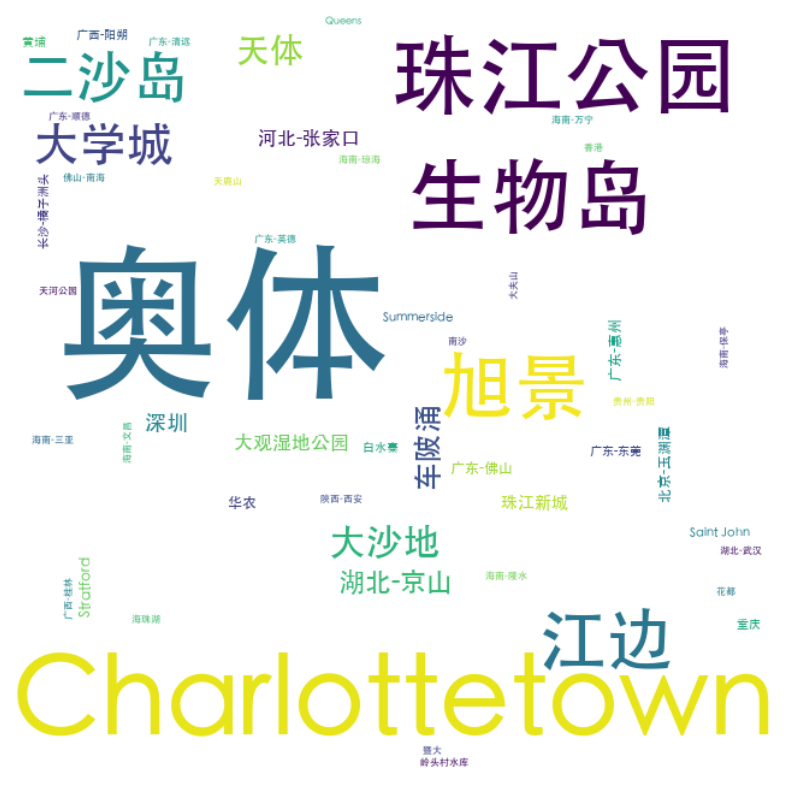

In [60]:
from wordcloud import WordCloud
from PIL import Image
text = ' '.join(df_run['Place'])
font_path = '/Users/deng/anaconda3/lib/python3.1/site-packages/matplotlib/mpl-data/fonts/ttf/STHeitiTC-Medium-01.ttf'
run_mask = np.array(Image.open("/Users/deng/Downloads/running.png"))
#run_mask[run_mask == 0] = 255
place_freq = df_run.groupby('Place').size().to_dict()
wordcloud = WordCloud(background_color="white", width=480, height=360, font_path=font_path, mask=run_mask, collocations=False).generate_from_frequencies(place_freq)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
print(place_freq)

{'Charlottetown': 210, 'Queens': 1, 'Saint John': 2, 'Stratford': 3, 'Summerside': 2, '二沙岛': 49, '佛山-南海': 1, '北京-玉渊潭': 3, '华农': 3, '南沙': 1, '大夫山': 1, '大学城': 32, '大沙地': 19, '大观湿地公园': 5, '天体': 15, '天河公园': 1, '天鹿山': 1, '奥体': 240, '岭头村水库': 1, '广东-东莞': 2, '广东-佛山': 3, '广东-惠州': 3, '广东-清远': 1, '广东-英德': 1, '广东-顺德': 1, '广西-桂林': 1, '广西-阳朔': 2, '旭景': 91, '暨大': 1, '江边': 74, '河北-张家口': 5, '海南-万宁': 1, '海南-三亚': 1, '海南-保亭': 1, '海南-文昌': 1, '海南-琼海': 1, '海南-陵水': 1, '海珠湖': 1, '深圳': 6, '湖北-京山': 9, '湖北-武汉': 1, '珠江公园': 126, '珠江新城': 4, '生物岛': 115, '白水寨': 2, '花都': 1, '贵州-贵阳': 1, '车陂涌': 11, '重庆': 2, '长沙-橘子洲头': 2, '陕西-西安': 1, '香港': 1, '黄埔': 2}
